In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [74]:
warnings.filterwarnings('ignore')
sns.set(font_scale=1.5, rc={'figure.figsize':(10, 7)}, style='whitegrid')
np.random.seed(1)

## Loading data

In [3]:
ins_data = pd.read_csv('data_for_lm/insurance.csv')
ins_data.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [4]:
ins_data.shape

(1338, 7)

## Cheking data types

In [7]:
ins_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

## Some EDA

In [8]:
ins_data[ins_data.duplicated()]

age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631

In [9]:
# Drop duplicates
ins_data = ins_data.drop_duplicates()

In [10]:
ins_data.shape

(1337, 7)

In [11]:
ins_data.count()

age         1337
sex         1337
bmi         1337
children    1337
smoker      1337
region      1337
charges     1337
dtype: int64

There are no missing values by the first check, but it can be masked with 9999 or smth else..multiple plots on one figure matplotlib

In [12]:
ins_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We can see that here we have 4 groups based on $smoker$ and $sex$ variables. This groups are not pretty balanced, so we have to take it into account.

In [13]:
ins_pivot = ins_data.pivot_table(index=['smoker', 'sex'], aggfunc='count')
ins_pivot

age  bmi  charges  children  region
smoker sex                                        
no     female  547  547      547       547     547
       male    516  516      516       516     516
yes    female  115  115      115       115     115
       male    159  159      159       159     159

We can see that if you smokes you habe a higher charges.

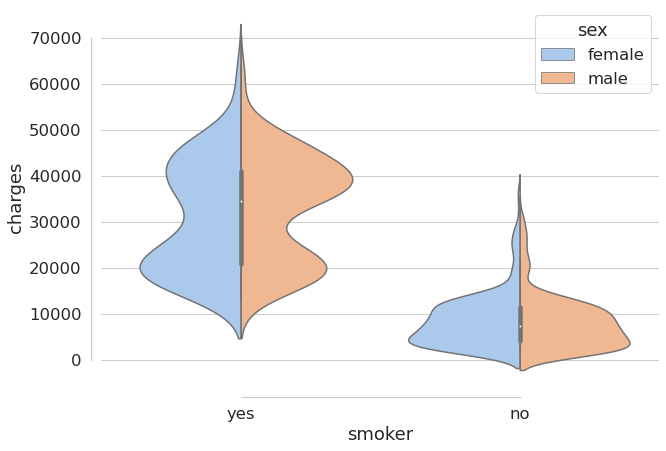

In [22]:
sns.violinplot(hue="sex", y='charges', x='smoker', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

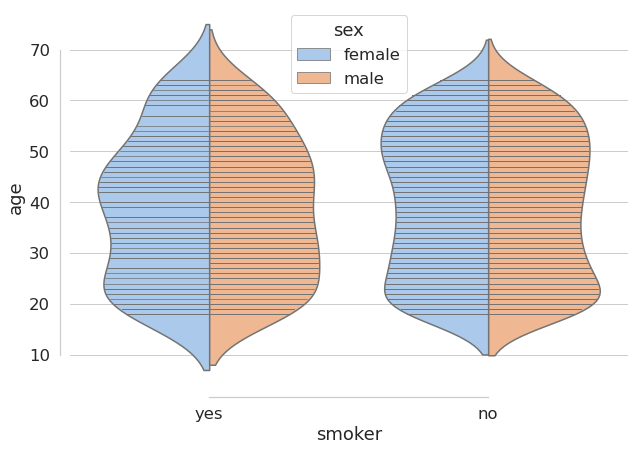

In [20]:
sns.violinplot(hue="sex", y='age', x='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

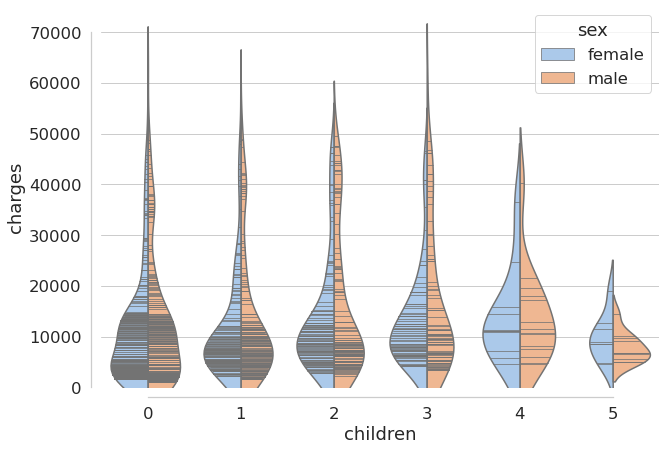

In [31]:
sns.violinplot(hue="sex", y='charges', x='children', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
plt.ylim(0, 75000)
sns.despine(offset=10, trim=True)

<AxesSubplot:xlabel='region', ylabel='children'>

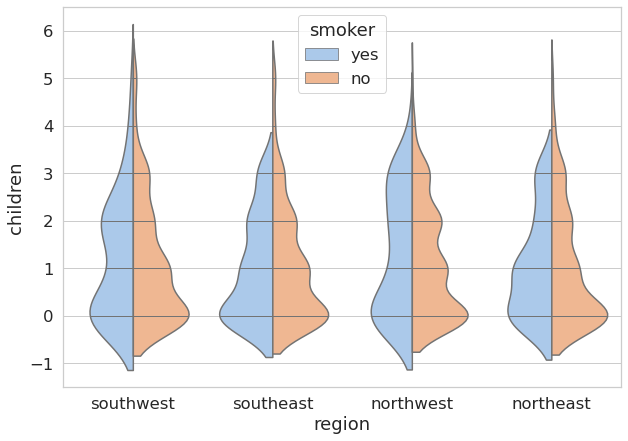

In [45]:
sns.violinplot(y='children', x='region', hue='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)

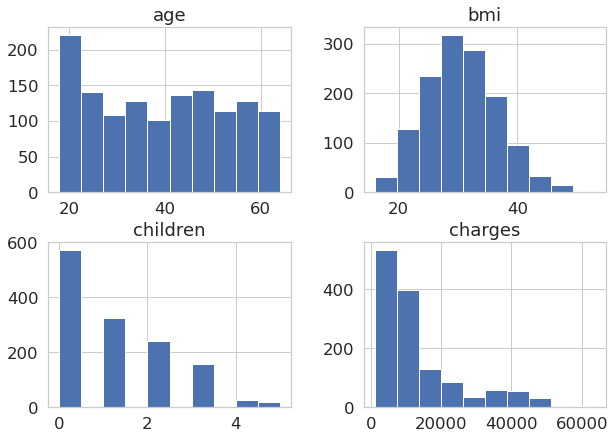

In [26]:
ins_data.hist()
plt.show()

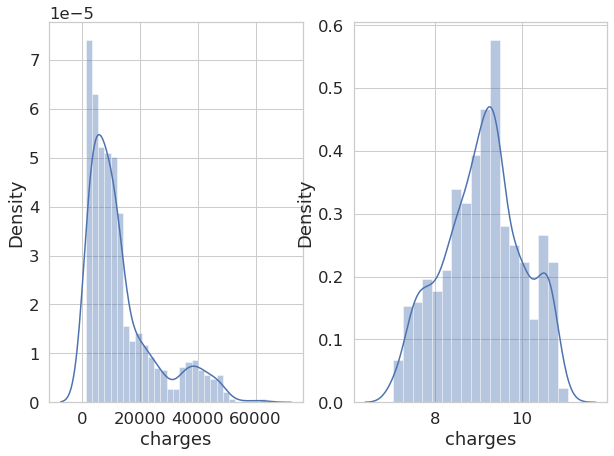

In [41]:
fig, axs = plt.subplots(1, 2)
sns.distplot(ins_data['charges'], ax=axs[0])
sns.distplot(np.log(ins_data['charges']), ax=axs[1])
plt.show()

So we want to use linnear regression and dependent variable must have normal distribution. So I will transform our dependent variable $charges$ with log transformation.

<AxesSubplot:>

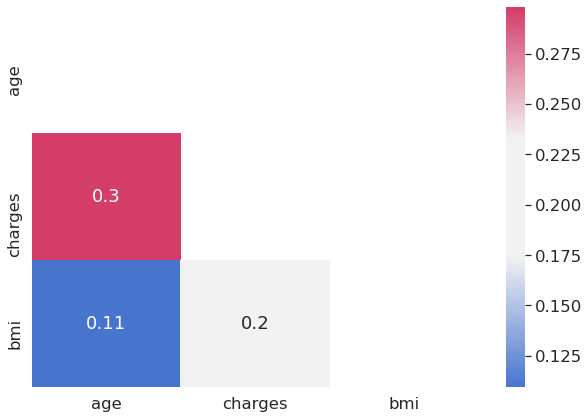

In [49]:
corr = ins_data.loc[:, ['age', 'charges', 'bmi']].corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
mask = np.ones((3, 3)) - mask + np.eye(3)
sns.heatmap(corr, cmap=sns.diverging_palette(256, 0, sep=80, as_cmap=True), annot=True, mask=mask)

Here we can see some correlations between our quantitative variables, especially in groups based on $smoker$ variable.

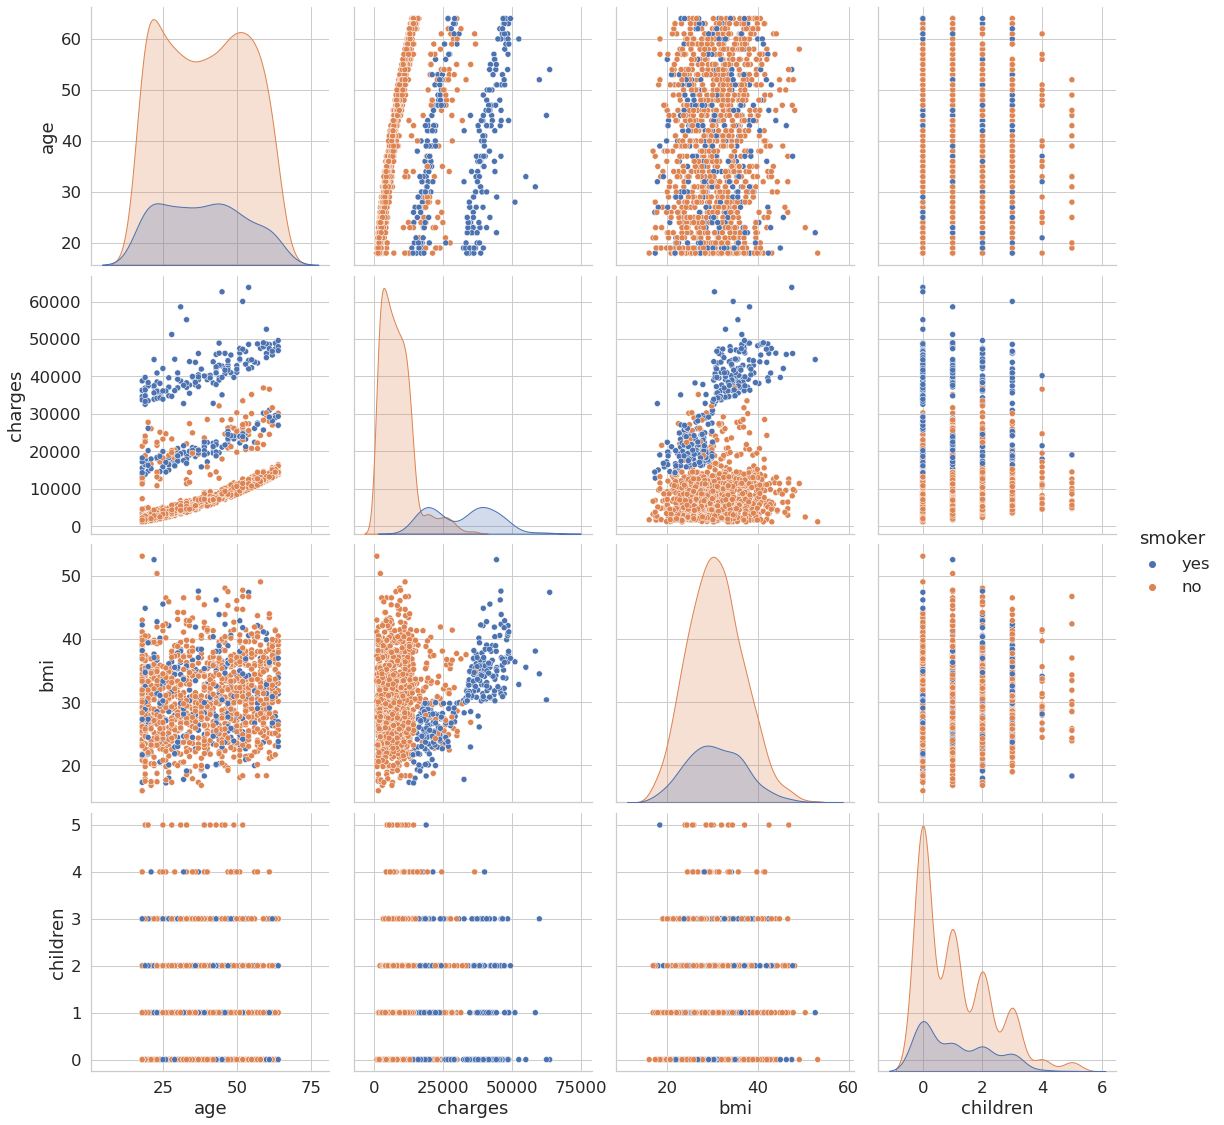

In [46]:
sns.pairplot(data=ins_data, height=4, hue='smoker', 
             x_vars=['age', 'charges', 'bmi', 'children'],
             y_vars=['age', 'charges', 'bmi', 'children'])

In [50]:
ins_data['log_charges'] = np.log(ins_data.charges)

In [51]:
ins_data.head()

age     sex     bmi  children smoker     region      charges  log_charges
0   19  female  27.900         0    yes  southwest  16884.92400     9.734176
1   18    male  33.770         1     no  southeast   1725.55230     7.453302
2   28    male  33.000         3     no  southeast   4449.46200     8.400538
3   33    male  22.705         0     no  northwest  21984.47061     9.998092
4   32    male  28.880         0     no  northwest   3866.85520     8.260197

Provide stratified train-test split to get balanced train and test data sets by $sex$ and $smoker$ vars.

In [156]:
X = ins_data.drop(['charges', 'log_charges'], axis=1)
y = ins_data['log_charges']

X.age = (X.age - X.age.mean()) / X.age.std()
X.bmi = (X.bmi - X.bmi.mean()) / X.bmi.std()
y = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X[['sex', 'smoker']])

X_train = pd.get_dummies(X_train, columns=['sex', 'smoker','region'])
X_test = pd.get_dummies(X_test, columns=['sex', 'smoker','region'])

In [158]:
log_charges_lm = LinearRegression()
log_charges_lm.fit(X_train, y_train)
log_charges_lm.score(X_test, y_test)

0.7144018183229923

Lets try to create model without region variable.

In [184]:
X_wo_region_train = X_train.loc[:, ~X_train.columns.str.startswith('region')]
X_wo_region_test = X_test.loc[:, ~X_test.columns.str.startswith('region')]

In [186]:
log_charges_lm_2 = LinearRegression()
log_charges_lm_2.fit(X_wo_region_train, y_train)
log_charges_lm_2.score(X_wo_region_test, y_test)

0.7151060249799284

So it doesn't improve performance at all)))